# Analyse results
Here we will analyze the first results of the experiments

## Data Loading
We load the data and merge the  different files. Furthermore, we rename the variables for ansatz, optimizer and featuremap to make the more user friendly.


In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns 

from scipy.stats import friedmanchisquare,  wilcoxon, kruskal, mannwhitneyu

sns.set(font_scale=1.25)
sns.set(style='white', palette=None)

In [7]:
declare = True
res = []

for noise, noise_string in zip(['none', 'ibm_perth'], ['_', 'ibm_perth']):
    for init in ['uniform', 'beta', 'normal']:
        res_current = []
        for optimizer in ['cobyla', 'spsa', 'neldermead']:
            for preprocessing in ['pca', 'lda']:
                res_current.append(pd.read_csv('../reports/results/covtype_' + noise_string + '_' + optimizer + '_' + preprocessing + "_" + init + "_" + 'results.csv', index_col=0))
        res_current = pd.concat(res_current)
        res_current['noise'] = noise
        res_current['initialization'] = init
        res.append(res_current)
res = pd.concat(res)
res.head()

,accuracy,f1,time,ansatz,optimizer,featuremap,entanglement,entanglement_featuremap,iterations,preprocessing,noise,initialization
index,,,,,,,,,,,,
20,0.388,0.400295,2420.290704,<function get_efficientsu2 at 0x7f12c6ccdee0>,<function get_cobyla at 0x7f12c6ccdf70>,<function get_zfeaturemap at 0x7f12f6cde040>,full,NaN,366,pca,none,uniform
21,0.416,0.420907,2218.388021,<function get_efficientsu2 at 0x7f12c6ccdee0>,<function get_cobyla at 0x7f12c6ccdf70>,<function get_zfeaturemap at 0x7f12f6cde040>,linear,NaN,382,pca,none,uniform
22,0.372,0.366136,2906.625933,<function get_efficientsu2 at 0x7f12c6ccdee0>,<function get_cobyla at 0x7f12c6ccdf70>,<function get_zfeaturemap at 0x7f12f6cde040>,circular,NaN,498,pca,none,uniform
23,0.340,0.377742,1592.723581,<function get_efficientsu2 at 0x7f12c6ccdee0>,<function get_cobyla at 0x7f12c6ccdf70>,<function get_zfeaturemap at 0x7f12f6cde040>,sca,NaN,269,pca,none,uniform
24,0.188,0.245629,2239.140502,<function get_efficientsu2 at 0x7f12c6ccdee0>,<function get_cobyla at 0x7f12c6ccdf70>,<function get_zzfeaturemap at 0x7f12f6cde0d0>,full,full,223,pca,none,uniform


In [8]:
# if ansatz contains 'efficientsu2' replace with 'efficient_su2'
res['ansatz'] = res['ansatz'].apply(lambda x: 'efficient_su2' if 'efficientsu2' in x else x)
# if ansatz = 'paulitwodesign' replace with 'pauli_two_design'
res['ansatz'] = res['ansatz'].apply(lambda x: 'pauli_two_design' if 'paulitwodesign' in x else x)
# if ansatz = 'realamplitudes' replace with 'real_amplitudes'
res['ansatz'] = res['ansatz'].apply(lambda x: 'real_amplitudes' if 'realamplitudes' in x else x)
# if ansatz = 'twolocal' replace with 'two_local'
res['ansatz'] = res['ansatz'].apply(lambda x: 'two_local' if 'twolocal' in x else x)
# otherwise drop
res = res[res['ansatz'].isin(['efficient_su2', 'pauli_two_design', 'real_amplitudes', 'two_local'])]

In [9]:
# if optimizer contains 'cobyla' replace with 'cobyla'
res['optimizer'] = res['optimizer'].apply(lambda x: 'cobyla' if 'cobyla' in x else x)
# if optimizer = 'lbfgsb' replace with 'l_bfgs_b'
res['optimizer'] = res['optimizer'].apply(lambda x: 'spsa' if 'spsa' in x else x)
# if optimizer = 'neldermead' replace with 'nelder_mead'
res['optimizer'] = res['optimizer'].apply(lambda x: 'nelder_mead' if 'neldermead' in x else x)

In [10]:
# if feature_map contains 'pauli' replace with 'pauli'
res['featuremap'] = res['featuremap'].apply(lambda x: 'pauli' if 'pauli' in x else x)
# if feature_map = 'ZZFeatureMap' replace with 'zz'
res['featuremap'] = res['featuremap'].apply(lambda x: 'zz' if 'zzfeaturemap' in x else x)
# if feature_map = 'ZFeatureMap' replace with 'z'
res['featuremap'] = res['featuremap'].apply(lambda x: 'z' if 'zfeaturemap' in x else x)

In [11]:
index = ['ansatz', 'featuremap', 'entanglement', 'entanglement_featuremap', 'preprocessing', 'optimizer', 'initialization']

best_configs = res[res['accuracy'] > max(res['accuracy']) - 0.1]
worst_configs = res[res['accuracy'] < min(res['accuracy']) + 0.1]

In [12]:
# get absolute difference between noise and no noise
noise = res[res['noise'] == 'ibm_perth'].set_index(index).sort_index()
no_noise = res[res['noise'] == 'none'].set_index(index).sort_index()
diff = np.abs(noise['accuracy'] - no_noise['accuracy'])

In [13]:
most_similar = diff[diff < min(diff) + 0.05].reset_index()
least_similar = diff[diff > max(diff) - 0.05].reset_index()

In [14]:
print("Mean difference between noise and no noise: ", diff.mean())
print("Standard deviation of difference between noise and no noise: ", diff.std())

Mean difference between noise and no noise:  0.043216931216931216
Standard deviation of difference between noise and no noise:  0.03749482070176991


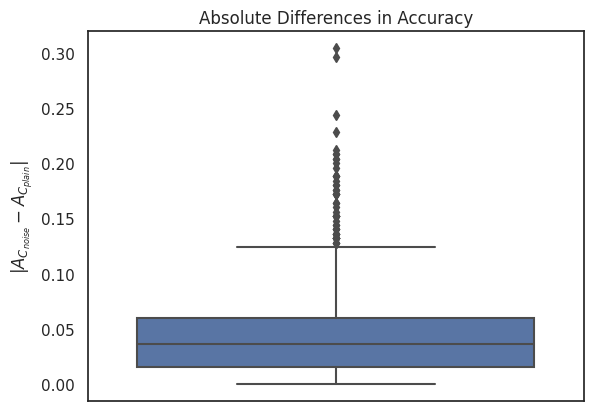

In [15]:
sns.boxplot(diff, palette='deep')
# name x tick of box plot
plt.xticks([0], [''])
plt.ylabel(r'$|{A}_{C_{noise}} - {A}_{C_{plain}}|$')
plt.title('Absolute Differences in Accuracy')
plt.savefig("../reports/figures/covtype_abs_diff.png")
plt.show()

In [16]:
print("Min difference between noise and no noise: ", diff.min())
print("Max difference between noise and no noise: ", diff.max())

Min difference between noise and no noise:  0.0
Max difference between noise and no noise:  0.304


In [17]:
print("Results with noise significantly better ", wilcoxon(noise['accuracy'], no_noise['accuracy'], alternative='greater').pvalue < 0.05)

Results with noise significantly better  True


## Optimizer
We first consider the optimizer.
* All in all, NelderMead by far the worst
* COBYLA and Nelder-Mead with an without noise significantly different
* Interestingly, SPSA make up the biggest part of the least similar configurations

In [18]:
res.groupby(['optimizer', 'noise']).agg({"accuracy":[np.mean, np.median, np.std], "f1":[np.mean, np.median, np.std]})

accuracy                         f1                    
                           mean median       std      mean    median       std
optimizer   noise                                                             
cobyla      ibm_perth  0.306865  0.244  0.133255  0.336183  0.302467  0.107464
            none       0.302548  0.230  0.143797  0.332040  0.288515  0.116699
nelder_mead ibm_perth  0.184421  0.184  0.051220  0.227104  0.231755  0.056376
            none       0.166063  0.164  0.052867  0.211089  0.215666  0.058777
spsa        ibm_perth  0.312349  0.268  0.123042  0.339698  0.317190  0.097437
            none       0.319627  0.256  0.138423  0.346251  0.309734  0.110189

In [19]:
c = res[res['optimizer'] == 'cobyla'].set_index(index).sort_index()
n = res[res['optimizer'] == 'nelder_mead'].set_index(index).sort_index()
s = res[res['optimizer'] == 'spsa'].set_index(index).sort_index()

In [20]:
# Wilcoxon
print("Wilcoxon: Cobyla without noise significantly worse:", wilcoxon(c.loc[c['noise'] == 'none','accuracy'].sort_index(), c.loc[c['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: SPSA without noise significantly better",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'].sort_index(), s.loc[s['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Nelder Mead without noise significantly worse:",  wilcoxon(n.loc[n['noise'] == 'none','accuracy'].sort_index(), n.loc[n['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)

Wilcoxon: Cobyla without noise significantly worse: True
Wilcoxon: SPSA without noise significantly better True
Wilcoxon: Nelder Mead without noise significantly worse: True


In [21]:
# sort by performance
res = res.sort_values(by=['f1', 'accuracy'], ascending=False).reset_index(drop=True)
res.head()

,accuracy,f1,time,ansatz,optimizer,featuremap,entanglement,entanglement_featuremap,iterations,preprocessing,noise,initialization
0,0.612,0.612969,2066.810829,efficient_su2,cobyla,zz,circular,linear,359,lda,none,beta
1,0.608,0.612726,2097.919316,efficient_su2,spsa,zz,linear,sca,351,lda,none,beta
2,0.612,0.610460,886.946526,pauli_two_design,cobyla,zz,NaN,pairwise,180,lda,none,beta
3,0.616,0.609562,1422.007794,real_amplitudes,spsa,z,linear,NaN,351,lda,none,normal
4,0.612,0.605096,2100.127136,efficient_su2,spsa,zz,circular,circular,351,lda,none,beta


In [22]:
most_similar.value_counts(['optimizer'])/res.value_counts(['optimizer'])

optimizer  
cobyla         0.327381
nelder_mead    0.326389
spsa           0.348214
Name: count, dtype: float64

In [23]:
least_similar.value_counts(['optimizer'])/res.value_counts(['optimizer'])

optimizer  
cobyla              NaN
nelder_mead    0.001984
spsa                NaN
Name: count, dtype: float64

## Ansatz
We now consider the ansatz parameter alone.
* All ansatzes, except PauliTwoDesign, perform signficantly different with and without noise
* None of the Pauli configurations are among the least similar ones
* Other than that, comparable ratios in the most similar ones

In [24]:
res.groupby(['ansatz', 'noise']).agg({"accuracy":[np.mean, np.std], "f1":[np.mean, np.std]})

accuracy                  f1          
                                mean       std      mean       std
ansatz           noise                                            
efficient_su2    ibm_perth  0.263417  0.123378  0.297064  0.103197
                 none       0.261787  0.142452  0.295347  0.119003
pauli_two_design ibm_perth  0.262148  0.115743  0.298809  0.102491
                 none       0.246148  0.124184  0.281635  0.108685
real_amplitudes  ibm_perth  0.267194  0.126200  0.299167  0.106702
                 none       0.262250  0.137927  0.295506  0.117412
two_local        ibm_perth  0.273141  0.123748  0.306040  0.102568
                 none       0.267230  0.135855  0.301079  0.113230

In [25]:
e = res[res['ansatz'] == 'efficient_su2'].set_index(index)
p = res[res['ansatz'] == 'pauli_two_design'].set_index(index)
r = res[res['ansatz'] == 'real_amplitudes'].set_index(index)
t = res[res['ansatz'] == 'two_local'].set_index(index)

In [26]:
# Wilcoxon
print("Wilcoxon: EfficientSU2 with and without noise significantly different:", wilcoxon(e.loc[e['noise'] == 'none','accuracy'], e.loc[e['noise'] != 'none', 'accuracy']).pvalue < 0.05)
print("Wilcoxon: PauliTwoDesign without noise significantly better:",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'], s.loc[s['noise'] != 'none', 'accuracy'], alternative='greater').pvalue < 0.05)
print("Wilcoxon: RealAmplitudes without noise significantly worse:",  wilcoxon(r.loc[r['noise'] == 'none','accuracy'], r.loc[r['noise'] != 'none', 'accuracy'], alternative='less').pvalue < 0.05)
print("Wilcoxon: TwoLocal without noise significantly worse:",  wilcoxon(t.loc[t['noise'] == 'none','accuracy'], t.loc[t['noise'] != 'none', 'accuracy'], alternative='less').pvalue < 0.05)

Wilcoxon: EfficientSU2 with and without noise significantly different: True
Wilcoxon: PauliTwoDesign without noise significantly better: True
Wilcoxon: RealAmplitudes without noise significantly worse: True
Wilcoxon: TwoLocal without noise significantly worse: True


In [27]:
most_similar.value_counts(['ansatz'])/res.value_counts(['ansatz'])

ansatz          
two_local           0.345370
efficient_su2       0.335648
real_amplitudes     0.324074
pauli_two_design    0.310185
Name: count, dtype: float64

In [28]:
least_similar.value_counts(['ansatz'])/res.value_counts(['ansatz'])

ansatz          
efficient_su2            NaN
pauli_two_design         NaN
real_amplitudes     0.002315
two_local                NaN
Name: count, dtype: float64

## Ansatz Entanglement
* Circular, full and linear entanglement with and without noise are significantly different
* Does not apply for pairwise and sca
* Still, no full configurations are among the least similar ones
* Pairwise has the biggest ratio among the least similar configs

In [29]:
res.groupby(['entanglement', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1             
                            mean median       std      mean    median   
entanglement noise                                                      
circular     ibm_perth  0.266000  0.220  0.125107  0.299079  0.273322  \
             none       0.260160  0.200  0.140995  0.295152  0.260060   
full         ibm_perth  0.273630  0.228  0.118667  0.304485  0.275393   
             none       0.270593  0.208  0.136502  0.303204  0.262349   
linear       ibm_perth  0.263358  0.216  0.129602  0.296840  0.268235   
             none       0.258679  0.202  0.141432  0.291295  0.262039   
pairwise     ibm_perth  0.281704  0.240  0.123375  0.312934  0.290198   
             none       0.272926  0.226  0.135996  0.306672  0.272446   
sca          ibm_perth  0.265827  0.214  0.124472  0.300325  0.267603   
             none       0.263691  0.208  0.136140  0.297727  0.261755   

                                  
                             std  
entanglement noise                
circular     ibm_perth  0.105993  
             none       0.120000  
full         ibm_perth  0.098118  
             none       0.113606  
linear       ibm_perth  0.109287  
             none       0.118058  
pairwise     ibm_perth  0.097934  
             none       0.112569  
sca          ibm_perth  0.104699  
             none       0.114774

In [30]:
c = res[res['entanglement'] == 'circular'].set_index(index)
f = res[res['entanglement'] == 'full'].set_index(index)
l = res[res['entanglement'] == 'linear'].set_index(index)
p = res[res['entanglement'] == 'pairwise'].set_index(index)
s = res[res['entanglement'] == 'sca'].set_index(index)

In [31]:
# Wilcoxon
print("Wilcoxon: Circular without noise significantly worse:", wilcoxon(c.loc[c['noise'] == 'none','accuracy'].sort_index(), c.loc[c['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Full without noise significantly worse:",  wilcoxon(f.loc[f['noise'] == 'none','accuracy'].sort_index(), f.loc[f['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Linear with and without noise significantly different:",  wilcoxon(l.loc[l['noise'] == 'none','accuracy'].sort_index(), l.loc[l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: Pairwise without noise significantly worse:",  wilcoxon(p.loc[p['noise'] == 'none','accuracy'].sort_index(), p.loc[p['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Sca without noise significantly better:",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'].sort_index(), s.loc[s['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)

Wilcoxon: Circular without noise significantly worse: True
Wilcoxon: Full without noise significantly worse: True
Wilcoxon: Linear with and without noise significantly different: False
Wilcoxon: Pairwise without noise significantly worse: False
Wilcoxon: Sca without noise significantly better: False


In [32]:
most_similar.value_counts(['entanglement'])/res.value_counts(['entanglement'])

entanglement
circular        0.319444
full            0.316358
linear          0.350309
pairwise        0.305556
sca             0.367284
Name: count, dtype: float64

In [33]:
least_similar.value_counts(['entanglement'])/res.value_counts(['entanglement'])

entanglement
circular             NaN
full                 NaN
linear          0.001543
pairwise             NaN
sca             0.001543
Name: count, dtype: float64

## Ansatz combined with ansatz entanglement
* RealAmplitudes full is significantly different
* TwoLocal linear is significantly different
* No clear patterns alltogether

In [34]:
res.groupby(['ansatz', 'entanglement', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1   
                                            mean median       std      mean   
ansatz          entanglement noise                                            
efficient_su2   circular     ibm_perth  0.265333  0.216  0.125130  0.299036  \
                             none       0.257778  0.192  0.144216  0.292271   
                full         ibm_perth  0.268704  0.220  0.115374  0.302491   
                             none       0.267926  0.202  0.141678  0.301179   
                linear       ibm_perth  0.256741  0.212  0.128486  0.289481   
                             none       0.258407  0.200  0.142213  0.293408   
                sca          ibm_perth  0.262889  0.208  0.125542  0.297248   
                             none       0.263037  0.198  0.143444  0.294530   
real_amplitudes circular     ibm_perth  0.265778  0.220  0.130724  0.298970   
                             none       0.261444  0.204  0.139984  0.296566   
                full         ibm_perth  0.272296  0.222  0.119291  0.300877   
                             none       0.268630  0.210  0.138096  0.301293   
                linear       ibm_perth  0.266074  0.222  0.131513  0.299056   
                             none       0.255296  0.206  0.139855  0.284936   
                sca          ibm_perth  0.264630  0.214  0.124504  0.297764   
                             none       0.263630  0.212  0.135318  0.299228   
two_local       circular     ibm_perth  0.266889  0.226  0.120417  0.299232   
                             none       0.261259  0.204  0.140028  0.296619   
                full         ibm_perth  0.279889  0.236  0.122072  0.310086   
                             none       0.275222  0.212  0.130655  0.307140   
                linear       ibm_perth  0.267259  0.212  0.129740  0.301985   
                             none       0.262333  0.204  0.143436  0.295540   
                pairwise     ibm_perth  0.281704  0.240  0.123375  0.312934   
                             none       0.272926  0.226  0.135996  0.306672   
                sca          ibm_perth  0.269963  0.220  0.124419  0.305963   
                             none       0.264407  0.206  0.130616  0.299424   

                                                            
                                          median       std  
ansatz          entanglement noise                          
efficient_su2   circular     ibm_perth  0.266755  0.107314  
                             none       0.257632  0.123758  
                full         ibm_perth  0.272446  0.094940  
                             none       0.258766  0.117176  
                linear       ibm_perth  0.268235  0.106723  
                             none       0.254546  0.116256  
                sca          ibm_perth  0.266181  0.104335  
                             none       0.255398  0.120142  
real_amplitudes circular     ibm_perth  0.270363  0.110010  
                             none       0.265358  0.118937  
                full         ibm_perth  0.270013  0.098449  
                             none       0.263070  0.116877  
                linear       ibm_perth  0.270476  0.113271  
                             none       0.269924  0.118074  
                sca          ibm_perth  0.268832  0.105975  
                             none       0.268495  0.116703  
two_local       circular     ibm_perth  0.277943  0.101463  
                             none       0.260975  0.118299  
                full         ibm_perth  0.286560  0.101521  
                             none       0.265934  0.107454  
                linear       ibm_perth  0.267704  0.108387  
                             none       0.262700  0.120635  
                pairwise     ibm_perth  0.290198  0.097934  
                             none       0.272446  0.112569  
                sca          ibm_perth  0.270248  0.104527  
                             none       

In [35]:
for ansatz in ['efficient_su2', 'real_amplitudes', 'two_local']:
    e = res[res['ansatz']==ansatz]
    e_c = e[e['entanglement'] == 'circular'].set_index(index)
    e_f = e[e['entanglement'] == 'full'].set_index(index)
    e_l = e[e['entanglement'] == 'linear'].set_index(index)
    e_s = e[e['entanglement'] == 'sca'].set_index(index)

    # Wilcoxon
    print(ansatz, "Wilcoxon: Circular with and without noise significantly different:", wilcoxon(e_c.loc[e_c['noise'] == 'none','accuracy'].sort_index(), e_c.loc[e_c['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(ansatz, "Wilcoxon: Full with and without noise significantly different:",  wilcoxon(e_f.loc[e_f['noise'] == 'none','accuracy'].sort_index(), e_f.loc[e_f['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(ansatz, "Wilcoxon: Linear with and without noise significantly different:",  wilcoxon(e_l.loc[e_l['noise'] == 'none','accuracy'].sort_index(), e_l.loc[e_l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(ansatz, "Wilcoxon: Sca with and without noise significantly different:",  wilcoxon(e_s.loc[e_s['noise'] == 'none','accuracy'].sort_index(), e_s.loc[e_s['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

    if ansatz == 'two_local':
        e_p = e[e['entanglement'] == 'pairwise'].set_index(index).sort_index()
        print(ansatz, "Wilcoxon: Pairwise with and without noise significantly different:",  wilcoxon(e_p.loc[e_p['noise'] == 'none','accuracy'].sort_index(), e_p.loc[e_p['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

efficient_su2 Wilcoxon: Circular with and without noise significantly different: False
efficient_su2 Wilcoxon: Full with and without noise significantly different: False
efficient_su2 Wilcoxon: Linear with and without noise significantly different: False
efficient_su2 Wilcoxon: Sca with and without noise significantly different: False
real_amplitudes Wilcoxon: Circular with and without noise significantly different: False
real_amplitudes Wilcoxon: Full with and without noise significantly different: False
real_amplitudes Wilcoxon: Linear with and without noise significantly different: True
real_amplitudes Wilcoxon: Sca with and without noise significantly different: False
two_local Wilcoxon: Circular with and without noise significantly different: False
two_local Wilcoxon: Full with and without noise significantly different: False
two_local Wilcoxon: Linear with and without noise significantly different: False
two_local Wilcoxon: Sca with and without noise significantly different: Fals

In [36]:
most_similar.value_counts(['ansatz', 'entanglement'])/res.value_counts(['ansatz', 'entanglement'])

ansatz           entanglement
efficient_su2    circular        0.319444
                 full            0.324074
                 linear          0.342593
                 sca             0.356481
real_amplitudes  circular        0.324074
                 full            0.305556
                 linear          0.314815
                 sca             0.351852
two_local        circular        0.314815
                 full            0.319444
                 linear          0.393519
                 pairwise        0.305556
                 sca             0.393519
Name: count, dtype: float64

In [37]:
least_similar.value_counts(['ansatz', 'entanglement'])/res.value_counts(['ansatz', 'entanglement'])

ansatz           entanglement
efficient_su2    circular            NaN
                 full                NaN
                 linear              NaN
                 sca                 NaN
real_amplitudes  circular            NaN
                 full                NaN
                 linear          0.00463
                 sca             0.00463
two_local        circular            NaN
                 full                NaN
                 linear              NaN
                 pairwise            NaN
                 sca                 NaN
Name: count, dtype: float64

## Feature Map
* ZFeatureMap not significantly different with and without noise
* ZZFeatureMap is significantly different with and without noise
* But ZFeatureMap configuration are a lot more represented in the least similar configurations

In [38]:
res.groupby(['featuremap', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1                    
                          mean median       std      mean    median       std
featuremap noise                                                             
z          ibm_perth  0.361698  0.408  0.158348  0.347513  0.361669  0.135267
           none       0.363952  0.414  0.168392  0.350054  0.374794  0.143465
zz         ibm_perth  0.249114  0.216  0.106143  0.291691  0.267085  0.093756
           none       0.242505  0.196  0.120793  0.285741  0.253847  0.106281

In [39]:
z = res[res['featuremap'] == 'z'].set_index(index)
zz = res[res['featuremap'] == 'zz'].set_index(index)

In [40]:
# Wilcoxon
print("Wilcoxon: ZFeatureMap with and without noise significantly different:",  wilcoxon(z.loc[z['noise'] == 'none','accuracy'].sort_index(), z.loc[z['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: ZZFeatureMap without noise significantly worse:",  wilcoxon(zz.loc[zz['noise'] == 'none','accuracy'].sort_index(), zz.loc[zz['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)

Wilcoxon: ZFeatureMap with and without noise significantly different: False
Wilcoxon: ZZFeatureMap without noise significantly worse: True


In [41]:
most_similar.value_counts(['featuremap'])/res.value_counts(['featuremap'])

featuremap
zz            0.342063
z             0.293651
Name: count, dtype: float64

In [42]:
least_similar.value_counts(['featuremap'])/res.value_counts(['featuremap'])

featuremap
z             0.003968
zz                 NaN
Name: count, dtype: float64

## Feature Entanglement
* Circular, full, pairwise and sca are significantly different with and without noise
* Linear and None (ZFeatureMap) are not
* circular, full and pairwise not among least similar configs
* Also none (ZFeatureMap) less represented in most similar configs

In [43]:
res.groupby(['entanglement_featuremap', 'noise'], dropna=False).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1   
                                       mean median       std      mean   
entanglement_featuremap noise                                            
circular                ibm_perth  0.244206  0.208  0.108382  0.287764  \
                        none       0.236571  0.194  0.120432  0.279710   
full                    ibm_perth  0.238492  0.220  0.078064  0.282819   
                        none       0.228413  0.192  0.099229  0.276580   
linear                  ibm_perth  0.259063  0.216  0.118281  0.299367   
                        none       0.255429  0.212  0.123906  0.297438   
pairwise                ibm_perth  0.257825  0.220  0.117117  0.298962   
                        none       0.252921  0.204  0.132194  0.291166   
sca                     ibm_perth  0.245984  0.210  0.103155  0.289545   
                        none       0.239190  0.192  0.124447  0.283812   
NaN                     ibm_perth  0.361698  0.408  0.158348  0.347513   
                        none       0.363952  0.414  0.168392  0.350054   

                                                       
                                     median       std  
entanglement_featuremap noise                          
circular                ibm_perth  0.257848  0.097044  
                        none       0.248194  0.106782  
full                    ibm_perth  0.268020  0.071282  
                        none       0.249044  0.088951  
linear                  ibm_perth  0.270362  0.102553  
                        none       0.271993  0.106164  
pairwise                ibm_perth  0.273675  0.101722  
                        none       0.258962  0.114659  
sca                     ibm_perth  0.262783  0.092284  
                        none       0.250552  0.112404  
NaN                     ibm_perth  0.361669  0.135267  
                        none       0.374794  0.143465

In [44]:
c = res[res['entanglement_featuremap'] == 'circular'].set_index(index)
f = res[res['entanglement_featuremap'] == 'full'].set_index(index)
l = res[res['entanglement_featuremap'] == 'linear'].set_index(index)
p = res[res['entanglement_featuremap'] == 'pairwise'].set_index(index)
s = res[res['entanglement_featuremap'] == 'sca'].set_index(index)
n = res[res['entanglement_featuremap'].isna()].set_index(index)

# Wilcoxon
print("Wilcoxon: Circular without noise significantly different worse:", wilcoxon(c.loc[c['noise'] == 'none','accuracy'].sort_index(), c.loc[c['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Full without noise significantly worse:",  wilcoxon(f.loc[f['noise'] == 'none','accuracy'].sort_index(), f.loc[f['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Linear with and without noise significantly different:",  wilcoxon(l.loc[l['noise'] == 'none','accuracy'].sort_index(), l.loc[l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
print("Wilcoxon: Pairwise without noise significantly worse:",  wilcoxon(p.loc[p['noise'] == 'none','accuracy'].sort_index(), p.loc[p['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Sca without noise significantly worse:",  wilcoxon(s.loc[s['noise'] == 'none','accuracy'].sort_index(), s.loc[s['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: None with and without noise significantly different:",  wilcoxon(n.loc[n['noise'] == 'none','accuracy'].sort_index(), n.loc[n['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: Circular without noise significantly different worse: True
Wilcoxon: Full without noise significantly worse: True
Wilcoxon: Linear with and without noise significantly different: False
Wilcoxon: Pairwise without noise significantly worse: True
Wilcoxon: Sca without noise significantly worse: True
Wilcoxon: None with and without noise significantly different: False


In [45]:
most_similar.value_counts(['entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement_featuremap'], dropna=False)

entanglement_featuremap
circular                   0.349206
full                       0.321429
linear                     0.337302
pairwise                   0.357143
sca                        0.345238
NaN                        0.293651
Name: count, dtype: float64

In [46]:
least_similar.value_counts(['entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement_featuremap'], dropna=False)

entanglement_featuremap
circular                        NaN
full                            NaN
linear                          NaN
pairwise                        NaN
sca                             NaN
NaN                        0.003968
Name: count, dtype: float64

## Ansatz and feature map
* EfficientSU2 ansatz with both feature maps is significantly different
* PauliTwoDesign, RealAmplitudes and TwoLocal only with ZZFeatureMap significantly different
* Otherwise no new patterns

In [47]:
res.groupby(['ansatz', 'featuremap', 'noise']).agg({"accuracy": [np.mean, np.median, np.std], "f1": [np.mean, np.median, np.std]})

accuracy                         f1   
                                           mean median       std      mean   
ansatz           featuremap noise                                            
efficient_su2    z          ibm_perth  0.349333  0.382  0.159192  0.335575  \
                            none       0.368667  0.420  0.162593  0.350971   
                 zz         ibm_perth  0.246233  0.208  0.107175  0.289362   
                            none       0.240411  0.192  0.128003  0.284222   
pauli_two_design z          ibm_perth  0.342889  0.318  0.124593  0.345624   
                            none       0.339333  0.360  0.122448  0.342460   
                 zz         ibm_perth  0.246000  0.218  0.107511  0.289446   
                            none       0.227511  0.182  0.116488  0.269470   
real_amplitudes  z          ibm_perth  0.363500  0.426  0.166859  0.347610   
                            none       0.355667  0.434  0.182289  0.339775   
                 zz         ibm_perth  0.247933  0.212  0.106687  0.289478   
                            none       0.243567  0.200  0.119026  0.286652   
two_local        z          ibm_perth  0.373911  0.410  0.158030  0.357362   
                            none       0.371733  0.418  0.171026  0.359061   
                 zz         ibm_perth  0.252987  0.220  0.104835  0.295775   
                            none       0.246329  0.202  0.117182  0.289482   

                                                           
                                         median       std  
ansatz           featuremap noise                          
efficient_su2    z          ibm_perth  0.349102  0.133872  
                            none       0.381887  0.133437  
                 zz         ibm_perth  0.265417  0.094256  
                            none       0.250943  0.112854  
pauli_two_design z          ibm_perth  0.341918  0.101936  
                            none       0.373012  0.092344  
                 zz         ibm_perth  0.267066  0.100559  
                            none       0.238089  0.108049  
real_amplitudes  z          ibm_perth  0.369142  0.145879  
                            none       0.372638  0.160641  
                 zz         ibm_perth  0.265062  0.094314  
                            none       0.257839  0.104763  
two_local        z          ibm_perth  0.361669  0.134645  
                            none       0.382830  0.146449  
                 zz         ibm_perth  0.270978  0.091661  
                            none       0.259595  0.101641

In [48]:
for ansatz in pd.unique(res['ansatz']):
    f = res[res['ansatz'] == ansatz]
    z = f[f['featuremap'] == 'z'].set_index(index)
    zz = f[f['featuremap'] == 'zz'].set_index(index)

    # Wilcoxon
    print(f"Wilcoxon: ZFeaturemap with {ansatz} with and without noise significantly different:",  wilcoxon(z.loc[z['noise'] == 'none','accuracy'].sort_index(), z.loc[z['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)
    print(f"Wilcoxon: ZZFeatureMap with {ansatz} with and without noise significantly different:",  wilcoxon(zz.loc[zz['noise'] == 'none','accuracy'].sort_index(), zz.loc[zz['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: ZFeaturemap with efficient_su2 with and without noise significantly different: True
Wilcoxon: ZZFeatureMap with efficient_su2 with and without noise significantly different: True
Wilcoxon: ZFeaturemap with pauli_two_design with and without noise significantly different: False
Wilcoxon: ZZFeatureMap with pauli_two_design with and without noise significantly different: True
Wilcoxon: ZFeaturemap with real_amplitudes with and without noise significantly different: False
Wilcoxon: ZZFeatureMap with real_amplitudes with and without noise significantly different: True
Wilcoxon: ZFeaturemap with two_local with and without noise significantly different: False
Wilcoxon: ZZFeatureMap with two_local with and without noise significantly different: True


In [49]:
most_similar.value_counts(['ansatz', 'featuremap'], dropna=False)/res.value_counts(['ansatz', 'featuremap'], dropna=False)

ansatz            featuremap
two_local         zz            0.352222
efficient_su2     zz            0.338889
real_amplitudes   zz            0.337500
pauli_two_design  zz            0.322222
two_local         z             0.311111
efficient_su2     z             0.319444
real_amplitudes   z             0.256944
pauli_two_design  z             0.250000
Name: count, dtype: float64

In [50]:
least_similar.value_counts(['ansatz', 'featuremap'], dropna=False)/res.value_counts(['ansatz', 'featuremap'], dropna=False)

ansatz            featuremap
efficient_su2     z                  NaN
                  zz                 NaN
pauli_two_design  z                  NaN
                  zz                 NaN
real_amplitudes   z             0.013889
                  zz                 NaN
two_local         z                  NaN
                  zz                 NaN
Name: count, dtype: float64

## Ansatz and Featuremap Entanglement
* circular ansatz: full and pairwise feature entanglement significantly different
* full ansatz: full, pairwise and sca feature entanglement significantly different
* linear ansatz: circular feature entanglement significantly different

In [51]:
res.groupby(['entanglement', 'entanglement_featuremap', 'noise'], dropna=False).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1   
                                                    mean       std      mean   
entanglement entanglement_featuremap noise                                     
circular     circular                ibm_perth  0.244074  0.106398  0.288839  \
                                     none       0.236444  0.120951  0.281763   
             full                    ibm_perth  0.236741  0.074336  0.279405   
                                     none       0.223852  0.106552  0.273818   
             linear                  ibm_perth  0.258667  0.110297  0.297404   
...                                                  ...       ...       ...   
NaN          pairwise                none       0.236222  0.142927  0.276109   
             sca                     ibm_perth  0.242667  0.094309  0.288056   
                                     none       0.232667  0.110734  0.271410   
             NaN                     ibm_perth  0.342889  0.124593  0.345624   
                                     none       0.339333  0.122448  0.342460   

                                                          
                                                     std  
entanglement entanglement_featuremap noise                
circular     circular                ibm_perth  0.096127  
                                     none       0.109006  
             full                    ibm_perth  0.065856  
                                     none       0.095338  
             linear                  ibm_perth  0.095026  
...                                                  ...  
NaN          pairwise                none       0.130949  
             sca                     ibm_perth  0.093075  
                                     none       0.102592  
             NaN                     ibm_perth  0.101936  
                                     none       0.092344  

[72 rows x 4 columns]

In [52]:
for entanglement in pd.unique(res['entanglement']):
    f = res[res['entanglement'] == entanglement]
    f_c = f[f['entanglement_featuremap'] == 'circular'].set_index(index)
    f_f = f[f['entanglement_featuremap'] == 'full'].set_index(index)
    f_l = f[f['entanglement_featuremap'] == 'linear'].set_index(index)
    f_p = f[f['entanglement_featuremap'] == 'pairwise'].set_index(index)
    f_s = f[f['entanglement_featuremap'] == 'sca'].set_index(index)
    f_n = f[f['entanglement_featuremap'].isna()].set_index(index)

    # Wilcoxon
    sign = wilcoxon(f_c.loc[f_c['noise'] == 'none','accuracy'].sort_index(), f_c.loc[f_c['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Circular with and without noise significantly different:", sign)
    sign = wilcoxon(f_f.loc[f_f['noise'] == 'none','accuracy'].sort_index(), f_f.loc[f_f['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Full with and without noise significantly different:",  sign)
    sign = wilcoxon(f_l.loc[f_l['noise'] == 'none','accuracy'].sort_index(), f_l.loc[f_l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Linear with and without noise significantly different:",  sign)
    sign = wilcoxon(f_p.loc[f_p['noise'] == 'none','accuracy'].sort_index(), f_p.loc[f_p['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Pairwise with and without noise significantly different:", sign)
    sign = wilcoxon(f_s.loc[f_s['noise'] == 'none','accuracy'].sort_index(), f_s.loc[f_s['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: Sca with and without noise significantly different:", sign)
    sign = wilcoxon(f_n.loc[f_n['noise'] == 'none','accuracy'].sort_index(), f_n.loc[f_n['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05
    if sign:
        print(entanglement, "Wilcoxon: None with and without noise significantly different:",  sign)

full Wilcoxon: Full with and without noise significantly different: True
full Wilcoxon: None with and without noise significantly different: True


/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [53]:
most_similar.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)

/tmp/ipykernel_16931/2604937104.py:1: RuntimeWarning: The values in the array are unorderable. Pass `sort=False` to suppress this warning.
  most_similar.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)


entanglement  entanglement_featuremap
sca           sca                        0.416667
full          pairwise                   0.398148
sca           circular                   0.388889
linear        pairwise                   0.379630
sca           linear                     0.379630
circular      sca                        0.370370
linear        circular                   0.370370
              linear                     0.361111
              full                       0.361111
sca           NaN                        0.351852
circular      circular                   0.342593
sca           pairwise                   0.342593
linear        sca                        0.333333
full          sca                        0.333333
sca           full                       0.324074
full          circular                   0.314815
circular      full                       0.314815
              pairwise                   0.314815
full          linear                     0.305556
circular    

In [54]:
least_similar.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)/res.value_counts(['entanglement', 'entanglement_featuremap'], dropna=False)

entanglement  entanglement_featuremap
circular      circular                        NaN
              full                            NaN
              linear                          NaN
              pairwise                        NaN
              sca                             NaN
              NaN                             NaN
full          circular                        NaN
              full                            NaN
              linear                          NaN
              pairwise                        NaN
              sca                             NaN
              NaN                             NaN
linear        circular                        NaN
              full                            NaN
              linear                          NaN
              pairwise                        NaN
              sca                             NaN
              NaN                        0.009259
pairwise      circular                        NaN
            

## Preprocessing
* Both preprocessing techniques are significantly different with and without noise
* No other clear patterns

In [55]:
res.groupby(['preprocessing', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                             mean       std      mean       std
preprocessing noise                                            
lda           ibm_perth  0.284249  0.151648  0.310416  0.130613
              none       0.282915  0.165495  0.312004  0.142567
pca           ibm_perth  0.251508  0.084350  0.291574  0.066107
              none       0.242577  0.098273  0.280916  0.077587

In [56]:
p = res[res['preprocessing']=='pca'].set_index(index)
l = res[res['preprocessing']=='lda'].set_index(index)

In [57]:
# Wilcoxon
print("Wilcoxon: PCA without noise significantly worse:", wilcoxon(p.loc[p['noise'] == 'none','accuracy'].sort_index(), p.loc[p['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: LDA with and without noise significantly different:",  wilcoxon(l.loc[l['noise'] == 'none','accuracy'].sort_index(), l.loc[l['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: PCA without noise significantly worse: True
Wilcoxon: LDA with and without noise significantly different: False


In [58]:
most_similar.value_counts(['preprocessing'], dropna=False)/res.value_counts(['preprocessing'], dropna=False)

preprocessing
lda              0.330026
pca              0.337963
Name: count, dtype: float64

In [59]:
least_similar.value_counts(['preprocessing'], dropna=False)/res.value_counts(['preprocessing'], dropna=False)

preprocessing
lda              0.001323
pca                   NaN
Name: count, dtype: float64

## Initialization

In [60]:
res.groupby(['initialization', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                              mean       std      mean       std
initialization noise                                            
beta           ibm_perth  0.347095  0.148805  0.356549  0.129992
               none       0.355619  0.161185  0.362868  0.142459
normal         ibm_perth  0.227690  0.084424  0.272689  0.073213
               none       0.215032  0.094964  0.262141  0.081793
uniform        ibm_perth  0.228849  0.085445  0.273748  0.074403
               none       0.217587  0.094141  0.264370  0.081578

In [61]:
r = res[res['initialization']=='uniform'].set_index(index)
b = res[res['initialization']=='beta'].set_index(index)
n = res[res['initialization']=='normal'].set_index(index)

In [62]:
print("Wilcoxon: uniform without noise significantly worse:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index(), alternative='less').pvalue < 0.05)
print("Wilcoxon: Beta without noise significantly better:",  wilcoxon(b.loc[b['noise'] == 'none','accuracy'].sort_index(), b.loc[b['noise'] != 'none', 'accuracy'].sort_index(), alternative='greater').pvalue < 0.05)
print("Wilcoxon: Normal with and without noise significantly different:",  wilcoxon(n.loc[n['noise'] == 'none','accuracy'].sort_index(), n.loc[n['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: uniform without noise significantly worse: True
Wilcoxon: Beta without noise significantly better: True
Wilcoxon: Normal with and without noise significantly different: True


In [63]:
most_similar.value_counts(['initialization'], dropna=False)/res.value_counts(['initialization'], dropna=False)

initialization
beta              0.279762
normal            0.351190
uniform           0.371032
Name: count, dtype: float64

In [64]:
least_similar.value_counts(['initialization'], dropna=False)/res.value_counts(['initialization'], dropna=False)


initialization
beta              0.001984
normal                 NaN
uniform                NaN
Name: count, dtype: float64

### Initialization X Optimizer

In [65]:
res.groupby(['initialization', 'optimizer', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                          mean       std      mean       std
initialization optimizer   noise                                            
beta           cobyla      ibm_perth  0.425310  0.115537  0.425646  0.096685
                           none       0.445048  0.103438  0.441405  0.090770
               nelder_mead ibm_perth  0.188476  0.076825  0.219533  0.082526
                           none       0.170429  0.080201  0.204700  0.086245
               spsa        ibm_perth  0.427500  0.097337  0.424468  0.080052
                           none       0.451381  0.096697  0.442499  0.087739
normal         cobyla      ibm_perth  0.251738  0.096870  0.295736  0.081445
                           none       0.232881  0.102524  0.278653  0.085339
               nelder_mead ibm_perth  0.182024  0.031859  0.230549  0.035937
                           none       0.160976  0.030756  0.211620  0.038435
               spsa        ibm_perth  0.249310  0.088988  0.291781  0.074381
                           none       0.251238  0.105484  0.296152  0.085936
uniform        cobyla      ibm_perth  0.243548  0.097711  0.287166  0.081782
                           none       0.229714  0.102092  0.276062  0.086287
               nelder_mead ibm_perth  0.182762  0.030981  0.231231  0.037201
                           none       0.166786  0.031532  0.216948  0.037605
               spsa        ibm_perth  0.260238  0.090207  0.302846  0.075829
                           none       0.256262  0.105014  0.300101  0.086607

In [66]:
for init in pd.unique(res['initialization']):
    for optimizer in pd.unique(res['optimizer']):
        r = res[res['initialization']==init]
        r = r[r['optimizer']==optimizer]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {optimizer} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta cobyla with and without noise significantly different: True
Wilcoxon: beta spsa with and without noise significantly different: True
Wilcoxon: beta nelder_mead with and without noise significantly different: True
Wilcoxon: normal cobyla with and without noise significantly different: True
Wilcoxon: normal spsa with and without noise significantly different: False
Wilcoxon: normal nelder_mead with and without noise significantly different: True
Wilcoxon: uniform cobyla with and without noise significantly different: True
Wilcoxon: uniform spsa with and without noise significantly different: False
Wilcoxon: uniform nelder_mead with and without noise significantly different: True


In [67]:
most_similar.value_counts(['initialization', 'optimizer'])/res.value_counts(['initialization', 'optimizer'])

initialization  optimizer  
beta            cobyla         0.306548
                nelder_mead    0.217262
                spsa           0.315476
normal          cobyla         0.306548
                nelder_mead    0.375000
                spsa           0.372024
uniform         cobyla         0.369048
                nelder_mead    0.386905
                spsa           0.357143
Name: count, dtype: float64

In [68]:
least_similar.value_counts(['initialization', 'optimizer'])/res.value_counts(['initialization', 'optimizer'])

initialization  optimizer  
beta            cobyla              NaN
                nelder_mead    0.005952
                spsa                NaN
normal          cobyla              NaN
                nelder_mead         NaN
                spsa                NaN
uniform         cobyla              NaN
                nelder_mead         NaN
                spsa                NaN
Name: count, dtype: float64

### Initialization X Ansatz

In [69]:
res.groupby(['initialization', 'ansatz', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1   
                                               mean       std      mean   
initialization ansatz           noise                                     
beta           efficient_su2    ibm_perth  0.341500  0.152321  0.350917  \
                                none       0.358194  0.169432  0.363438   
               pauli_two_design ibm_perth  0.348778  0.141236  0.365988   
                                none       0.346889  0.147731  0.355630   
               real_amplitudes  ibm_perth  0.342611  0.155212  0.350740   
                                none       0.351861  0.161779  0.358653   
               two_local        ibm_perth  0.354822  0.142966  0.363813   
                                none       0.358311  0.157664  0.367232   
normal         efficient_su2    ibm_perth  0.224167  0.081651  0.270095   
                                none       0.209750  0.093074  0.258191   
               pauli_two_design ibm_perth  0.218222  0.073055  0.264117   
                                none       0.195222  0.079027  0.242810   
               real_amplitudes  ibm_perth  0.228056  0.084352  0.272636   
                                none       0.216000  0.100505  0.262671   
               two_local        ibm_perth  0.232111  0.089032  0.276520   
                                none       0.222444  0.094726  0.268745   
uniform        efficient_su2    ibm_perth  0.224583  0.082468  0.270180   
                                none       0.217417  0.098604  0.264412   
               pauli_two_design ibm_perth  0.219444  0.063958  0.266322   
                                none       0.196333  0.058463  0.246464   
               real_amplitudes  ibm_perth  0.230917  0.090558  0.274124   
                                none       0.218889  0.094500  0.265193   
               two_local        ibm_perth  0.232489  0.087646  0.277787   
                                none       0.220933  0.096077  0.267260   

                                                     
                                                std  
initialization ansatz           noise                
beta           efficient_su2    ibm_perth  0.133220  
                                none       0.149893  
               pauli_two_design ibm_perth  0.127800  
                                none       0.134990  
               real_amplitudes  ibm_perth  0.136414  
                                none       0.145646  
               two_local        ibm_perth  0.122975  
                                none       0.136109  
normal         efficient_su2    ibm_perth  0.069594  
                                none       0.078667  
               pauli_two_design ibm_perth  0.070711  
                                none       0.074631  
               real_amplitudes  ibm_perth  0.073943  
                                none       0.087331  
               two_local        ibm_perth  0.076241  
                                none       0.080884  
uniform        efficient_su2    ibm_perth  0.071601  
                                none       0.083691  
               pauli_two_design ibm_perth  0.061767  
                                none       0.062173  
               real_amplitudes  ibm_perth  0.078868  
                                none       0.081756  
               two_local        ibm_perth  0.075545  
                                none       0.083284

In [70]:
for initialization in pd.unique(res['initialization']):
    for ansatz in pd.unique(res['ansatz']):
        r = res[res['initialization']==initialization]
        r = r[r['ansatz']==ansatz]
        r = r.set_index(index)
        print(f"Wilcoxon: {initialization} {ansatz} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta efficient_su2 with and without noise significantly different: True
Wilcoxon: beta pauli_two_design with and without noise significantly different: False
Wilcoxon: beta real_amplitudes with and without noise significantly different: False
Wilcoxon: beta two_local with and without noise significantly different: False
Wilcoxon: normal efficient_su2 with and without noise significantly different: True
Wilcoxon: normal pauli_two_design with and without noise significantly different: True
Wilcoxon: normal real_amplitudes with and without noise significantly different: True
Wilcoxon: normal two_local with and without noise significantly different: True
Wilcoxon: uniform efficient_su2 with and without noise significantly different: True
Wilcoxon: uniform pauli_two_design with and without noise significantly different: True
Wilcoxon: uniform real_amplitudes with and without noise significantly different: True
Wilcoxon: uniform two_local with and without noise significantly differ

/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [71]:
most_similar.groupby(['initialization', 'ansatz']).size()/res.groupby(['initialization', 'ansatz']).size()

initialization  ansatz          
beta            efficient_su2       0.270833
                pauli_two_design    0.263889
                real_amplitudes     0.263889
                two_local           0.302778
normal          efficient_su2       0.368056
                pauli_two_design    0.319444
                real_amplitudes     0.326389
                two_local           0.363889
uniform         efficient_su2       0.368056
                pauli_two_design    0.347222
                real_amplitudes     0.381944
                two_local           0.369444
dtype: float64

In [72]:
least_similar.groupby(['initialization', 'ansatz']).size()/res.groupby(['initialization', 'ansatz']).size()

initialization  ansatz          
beta            efficient_su2            NaN
                pauli_two_design         NaN
                real_amplitudes     0.006944
                two_local                NaN
normal          efficient_su2            NaN
                pauli_two_design         NaN
                real_amplitudes          NaN
                two_local                NaN
uniform         efficient_su2            NaN
                pauli_two_design         NaN
                real_amplitudes          NaN
                two_local                NaN
dtype: float64

### Initialization X Ansatz Entanglement

In [73]:
res.groupby(['initialization', 'entanglement', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                           mean       std      mean       std
initialization entanglement noise                                            
beta           circular     ibm_perth  0.339370  0.153344  0.348537  0.136611
                            none       0.352852  0.169097  0.361782  0.151279
               full         ibm_perth  0.354259  0.140094  0.359476  0.121085
                            none       0.371074  0.151568  0.378022  0.133466
               linear       ibm_perth  0.340963  0.158085  0.352190  0.138582
                            none       0.347593  0.167291  0.351325  0.146046
               pairwise     ibm_perth  0.369667  0.136919  0.372631  0.111673
                            none       0.362778  0.154250  0.370593  0.131379
               sca          ibm_perth  0.345704  0.151589  0.357484  0.131436
                            none       0.351481  0.165183  0.360181  0.146137
normal         circular     ibm_perth  0.226704  0.083404  0.272350  0.070325
                            none       0.208407  0.090581  0.256150  0.079348
               full         ibm_perth  0.232000  0.081233  0.275572  0.070841
                            none       0.218852  0.099523  0.264802  0.082173
               linear       ibm_perth  0.223111  0.088754  0.268129  0.076498
                            none       0.214963  0.102765  0.261749  0.089655
               pairwise     ibm_perth  0.237667  0.087350  0.281157  0.072517
                            none       0.229889  0.100592  0.276513  0.087101
               sca          ibm_perth  0.228778  0.087897  0.274737  0.077095
                            none       0.219556  0.089917  0.267517  0.076105
uniform        circular     ibm_perth  0.231926  0.092807  0.276350  0.081203
                            none       0.219222  0.100721  0.267523  0.086607
               full         ibm_perth  0.234630  0.080234  0.278407  0.069274
                            none       0.221852  0.089879  0.266788  0.076926
               linear       ibm_perth  0.226000  0.093346  0.270201  0.079730
                            none       0.213481  0.099326  0.260810  0.085144
               pairwise     ibm_perth  0.237778  0.090658  0.285013  0.078009
                            none       0.226111  0.100829  0.272911  0.087074
               sca          ibm_perth  0.223000  0.079922  0.268753  0.070051
                            none       0.220037  0.094391  0.265483  0.081912

In [74]:
for init in pd.unique(res['initialization']):
    for entanglement in pd.unique(res['entanglement']):
        r = res[res['initialization']==init]
        r = r[r['entanglement']==entanglement]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {entanglement} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta circular with and without noise significantly different: True
Wilcoxon: beta linear with and without noise significantly different: False


/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Wilcoxon: beta nan with and without noise significantly different: False
Wilcoxon: beta full with and without noise significantly different: False
Wilcoxon: beta pairwise with and without noise significantly different: False
Wilcoxon: beta sca with and without noise significantly different: False
Wilcoxon: normal circular with and without noise significantly different: True
Wilcoxon: normal linear with and without noise significantly different: True
Wilcoxon: normal nan with and without noise significantly different: False
Wilcoxon: normal full with and without noise significantly different: True
Wilcoxon: normal pairwise with and without noise significantly different: False
Wilcoxon: normal sca with and without noise significantly different: True
Wilcoxon: uniform circular with and without noise significantly different: True
Wilcoxon: uniform linear with and without noise significantly different: True
Wilcoxon: uniform nan with and without noise significantly different: False
Wilcoxon

/home/sabrina/Documents/Conferences/SIAM 2024/code/venv/lib64/python3.11/site-packages/scipy/stats/_morestats.py:3414: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [75]:
most_similar.groupby(['initialization', 'entanglement']).size()/res.groupby(['initialization', 'entanglement']).size()

initialization  entanglement
beta            circular        0.273148
                full            0.236111
                linear          0.287037
                pairwise        0.263889
                sca             0.333333
normal          circular        0.324074
                full            0.333333
                linear          0.388889
                pairwise        0.333333
                sca             0.375000
uniform         circular        0.361111
                full            0.379630
                linear          0.375000
                pairwise        0.319444
                sca             0.393519
dtype: float64

In [76]:
least_similar.groupby(['initialization', 'entanglement']).size()/res.groupby(['initialization', 'entanglement']).size()

initialization  entanglement
beta            circular            NaN
                full                NaN
                linear          0.00463
                pairwise            NaN
                sca             0.00463
normal          circular            NaN
                full                NaN
                linear              NaN
                pairwise            NaN
                sca                 NaN
uniform         circular            NaN
                full                NaN
                linear              NaN
                pairwise            NaN
                sca                 NaN
dtype: float64

### Initialization X FeatureMap

In [77]:
res.groupby(['initialization', 'featuremap', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                         mean       std      mean       std
initialization featuremap noise                                            
beta           z          ibm_perth  0.397571  0.174667  0.324210  0.144311
                          none       0.389810  0.180236  0.319658  0.141252
               zz         ibm_perth  0.337000  0.141158  0.363016  0.126130
                          none       0.348781  0.156439  0.371510  0.141285
normal         z          ibm_perth  0.342571  0.146627  0.358232  0.128987
                          none       0.350048  0.163474  0.362989  0.144427
               zz         ibm_perth  0.204714  0.033503  0.255580  0.037129
                          none       0.188029  0.033867  0.241972  0.038114
uniform        z          ibm_perth  0.344952  0.147858  0.360096  0.130548
                          none       0.352000  0.159765  0.367514  0.141488
               zz         ibm_perth  0.205629  0.034509  0.256478  0.038417
                          none       0.190705  0.035167  0.243742  0.038265

In [78]:
for init in pd.unique(res['initialization']):
    for featmap in pd.unique(res['featuremap']):
        r = res[res['initialization']==init]
        r = r[r['featuremap']==featmap]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {featmap} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta zz with and without noise significantly different: True
Wilcoxon: beta z with and without noise significantly different: False
Wilcoxon: normal zz with and without noise significantly different: True
Wilcoxon: normal z with and without noise significantly different: False
Wilcoxon: uniform zz with and without noise significantly different: True
Wilcoxon: uniform z with and without noise significantly different: False


In [79]:
most_similar.groupby(['initialization', 'featuremap']).size()/res.groupby(['initialization', 'featuremap']).size()

initialization  featuremap
beta            z             0.279762
                zz            0.279762
normal          z             0.279762
                zz            0.365476
uniform         z             0.321429
                zz            0.380952
dtype: float64

In [80]:
least_similar.groupby(['initialization', 'featuremap']).size()/res.groupby(['initialization', 'featuremap']).size()

initialization  featuremap
beta            z             0.011905
                zz                 NaN
normal          z                  NaN
                zz                 NaN
uniform         z                  NaN
                zz                 NaN
dtype: float64

### Initialization X FeatureMap Entanglement

In [81]:
res.groupby(['initialization', 'entanglement_featuremap', 'noise'], dropna=False).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy             
                                                      mean       std   
initialization entanglement_featuremap noise                           
beta           circular                ibm_perth  0.331571  0.148548  \
                                       none       0.341476  0.158542   
               full                    ibm_perth  0.305524  0.098929   
                                       none       0.319619  0.125332   
               linear                  ibm_perth  0.356857  0.158454   
                                       none       0.365619  0.158189   
               pairwise                ibm_perth  0.353667  0.157952   
                                       none       0.371238  0.168454   
               sca                     ibm_perth  0.337381  0.130251   
                                       none       0.345952  0.166073   
               NaN                     ibm_perth  0.397571  0.174667   
                                       none       0.389810  0.180236   
normal         circular                ibm_perth  0.199190  0.026748   
                                       none       0.181714  0.029780   
               full                    ibm_perth  0.203286  0.030502   
                                       none       0.185762  0.026731   
               linear                  ibm_perth  0.209952  0.036394   
                                       none       0.196857  0.038261   
               pairwise                ibm_perth  0.213571  0.037728   
                                       none       0.192190  0.039593   
               sca                     ibm_perth  0.197571  0.032874   
                                       none       0.183619  0.031555   
               NaN                     ibm_perth  0.342571  0.146627   
                                       none       0.350048  0.163474   
uniform        circular                ibm_perth  0.201857  0.033921   
                                       none       0.186524  0.033477   
               full                    ibm_perth  0.206667  0.029742   
                                       none       0.179857  0.026609   
               linear                  ibm_perth  0.210381  0.036850   
                                       none       0.203810  0.038517   
               pairwise                ibm_perth  0.206238  0.033698   
                                       none       0.195333  0.040569   
               sca                     ibm_perth  0.203000  0.037911   
                                       none       0.188000  0.030747   
               NaN                     ibm_perth  0.344952  0.147858   
                                       none       0.352000  0.159765   

                                                        f1            
                                                      mean       std  
initialization entanglement_featuremap noise                          
beta           circular                ibm_perth  0.362086  0.132965  
                                       none       0.363776  0.145058  
               full                    ibm_perth  0.338640  0.089290  
                                       none       0.355112  0.112386  
               linear                  ibm_perth  0.375847  0.141485  
                                       none       0.382654  0.139793  
               pairwise                ibm_perth  0.372678  0.141541  
                                       none       0.383962  0.152295  
               sca                     ibm_perth  0.365830  0.117193  
                                       none       0.372047  0.154097  
               NaN                     ibm_perth  0.324210  0.144311  
                                       none       0.319658  0.141252  
normal         circular                ibm_perth  0.249537  0.030594  
                                       none       0.235764  0.034287  
               full               

In [82]:
for init in pd.unique(res['initialization']):
    for ent in pd.unique(res['entanglement_featuremap']):
        r = res[res['initialization']==init]
        r = r[r['entanglement_featuremap']==ent]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {ent} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta linear with and without noise significantly different: False
Wilcoxon: beta sca with and without noise significantly different: False
Wilcoxon: beta pairwise with and without noise significantly different: True
Wilcoxon: beta nan with and without noise significantly different: False
Wilcoxon: beta circular with and without noise significantly different: False
Wilcoxon: beta full with and without noise significantly different: False
Wilcoxon: normal linear with and without noise significantly different: True
Wilcoxon: normal sca with and without noise significantly different: True
Wilcoxon: normal pairwise with and without noise significantly different: True
Wilcoxon: normal nan with and without noise significantly different: False
Wilcoxon: normal circular with and without noise significantly different: True
Wilcoxon: normal full with and without noise significantly different: True
Wilcoxon: uniform linear with and without noise significantly different: False
Wilcoxon: u

In [83]:
most_similar.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()/res.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()

initialization  entanglement_featuremap
beta            circular                   0.297619
                full                       0.250000
                linear                     0.279762
                pairwise                   0.309524
                sca                        0.261905
                NaN                        0.279762
normal          circular                   0.380952
                full                       0.369048
                linear                     0.339286
                pairwise                   0.357143
                sca                        0.380952
                NaN                        0.279762
uniform         circular                   0.369048
                full                       0.345238
                linear                     0.392857
                pairwise                   0.404762
                sca                        0.392857
                NaN                        0.321429
dtype: float64

In [84]:
least_similar.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()/res.groupby(['initialization', 'entanglement_featuremap'], dropna=False).size()

initialization  entanglement_featuremap
beta            circular                        NaN
                full                            NaN
                linear                          NaN
                pairwise                        NaN
                sca                             NaN
                NaN                        0.011905
normal          circular                        NaN
                full                            NaN
                linear                          NaN
                pairwise                        NaN
                sca                             NaN
                NaN                             NaN
uniform         circular                        NaN
                full                            NaN
                linear                          NaN
                pairwise                        NaN
                sca                             NaN
                NaN                             NaN
dtype: float64

### Initialization X Preprocessing

In [85]:
res.groupby(['initialization', 'preprocessing', 'noise']).agg({"accuracy": [np.mean, np.std], "f1": [np.mean, np.std]})

accuracy                  f1          
                                            mean       std      mean       std
initialization preprocessing noise                                            
beta           lda           ibm_perth  0.393952  0.175495  0.389288  0.162841
                             none       0.403873  0.189266  0.398979  0.176204
               pca           ibm_perth  0.300238  0.095744  0.323809  0.072068
                             none       0.307365  0.107554  0.326757  0.083687
normal         lda           ibm_perth  0.230127  0.100276  0.271751  0.088183
                             none       0.222873  0.110148  0.270014  0.096185
               pca           ibm_perth  0.225254  0.064931  0.273626  0.054440
                             none       0.207190  0.076264  0.254268  0.063490
uniform        lda           ibm_perth  0.228667  0.100972  0.270207  0.087477
                             none       0.222000  0.111335  0.267017  0.097170
               pca           ibm_perth  0.229032  0.066597  0.277289  0.058448
                             none       0.213175  0.072979  0.261724  0.062292

In [86]:
for init in pd.unique(res['initialization']):
    for preprocessing in pd.unique(res['preprocessing']):
        r = res[res['initialization']==init]
        r = r[r['preprocessing']==preprocessing]
        r = r.set_index(index)
        print(f"Wilcoxon: {init} {preprocessing} with and without noise significantly different:", wilcoxon(r.loc[r['noise'] == 'none','accuracy'].sort_index(), r.loc[r['noise'] != 'none', 'accuracy'].sort_index()).pvalue < 0.05)

Wilcoxon: beta lda with and without noise significantly different: True
Wilcoxon: beta pca with and without noise significantly different: True
Wilcoxon: normal lda with and without noise significantly different: True
Wilcoxon: normal pca with and without noise significantly different: True
Wilcoxon: uniform lda with and without noise significantly different: True
Wilcoxon: uniform pca with and without noise significantly different: True


In [87]:
most_similar.groupby(['initialization', 'preprocessing']).size()/res.groupby(['initialization', 'preprocessing']).size()

initialization  preprocessing
beta            lda              0.250000
                pca              0.309524
normal          lda              0.355159
                pca              0.347222
uniform         lda              0.384921
                pca              0.357143
dtype: float64

In [88]:
least_similar.groupby(['initialization', 'preprocessing']).size()/res.groupby(['initialization', 'preprocessing']).size()

initialization  preprocessing
beta            lda              0.003968
                pca                   NaN
normal          lda                   NaN
                pca                   NaN
uniform         lda                   NaN
                pca                   NaN
dtype: float64

## Plot the Results

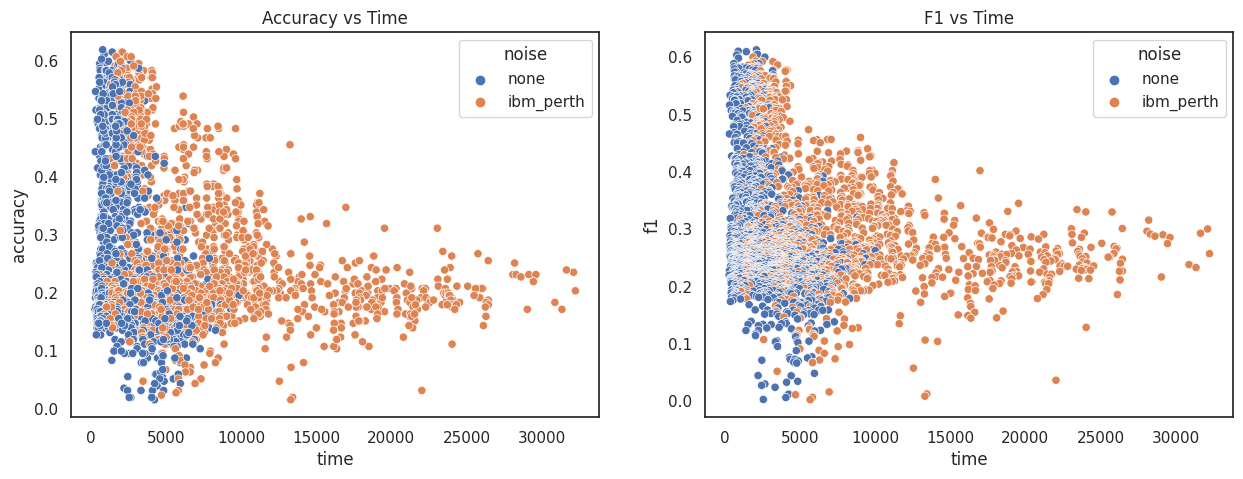

In [89]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.scatterplot(data=res, x='time', y='accuracy', hue='noise', ax=ax[0])
sns.scatterplot(data=res, x='time', y='f1', hue='noise', ax=ax[1])
ax[0].set_title('Accuracy vs Time')
ax[1].set_title('F1 vs Time')
plt.show()

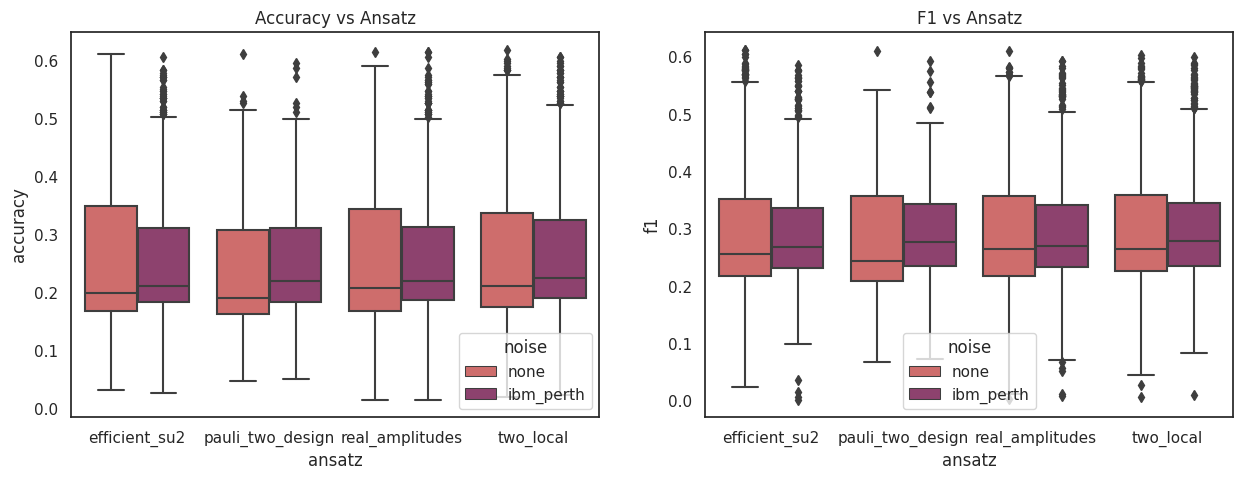

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=res, x='ansatz', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=res, x='ansatz', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Ansatz')
ax[1].set_title('F1 vs Ansatz')
plt.show()

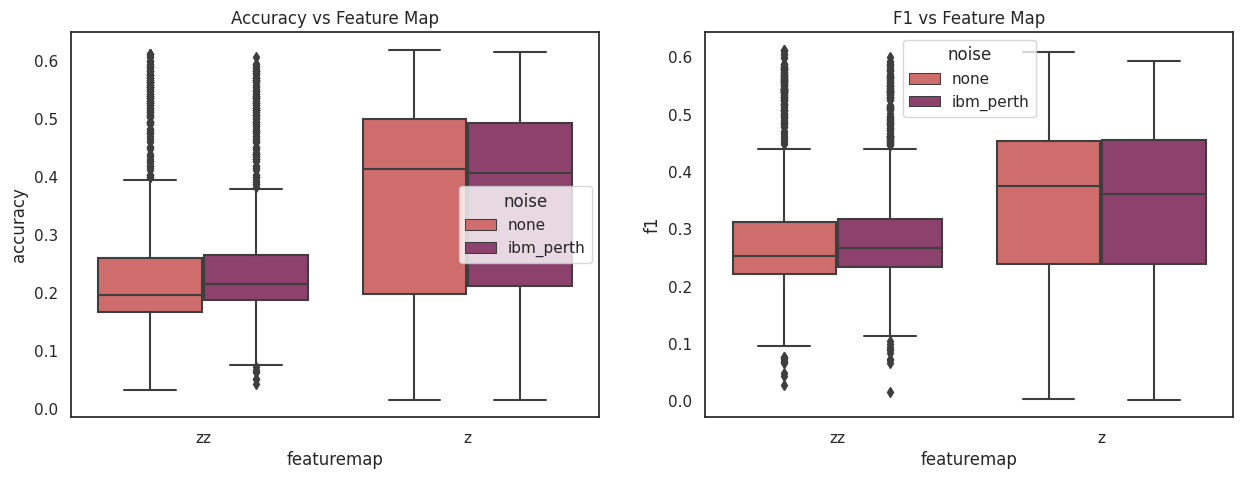

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=res, x='featuremap', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=res, x='featuremap', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Feature Map')
ax[1].set_title('F1 vs Feature Map')
plt.show()

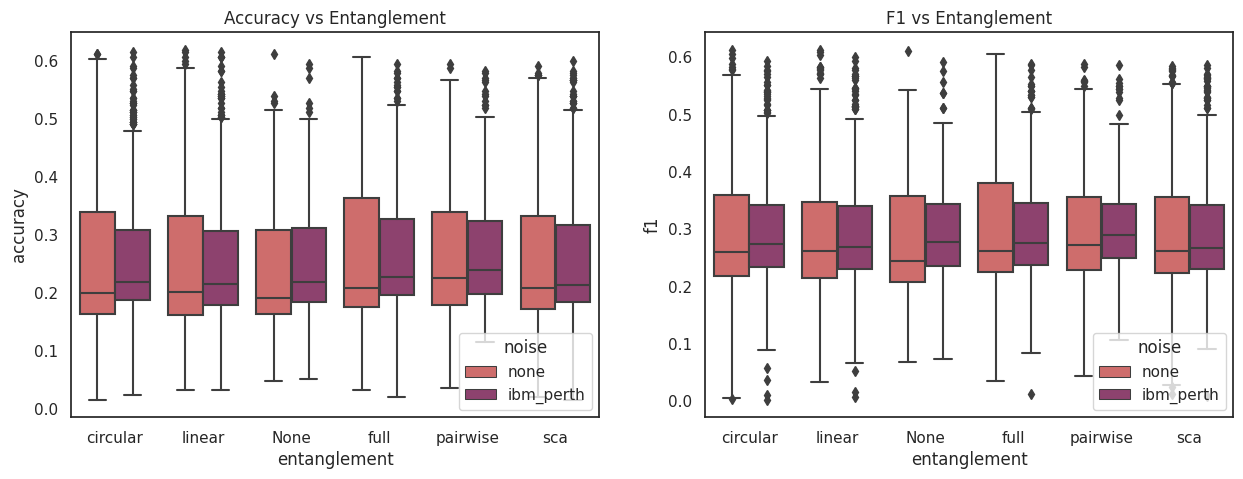

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
r = res.copy()
r.loc[r['entanglement'].isna(), 'entanglement'] = 'None'
sns.boxplot(data=r, x='entanglement', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=r, x='entanglement', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Entanglement')
ax[1].set_title('F1 vs Entanglement')
plt.show()

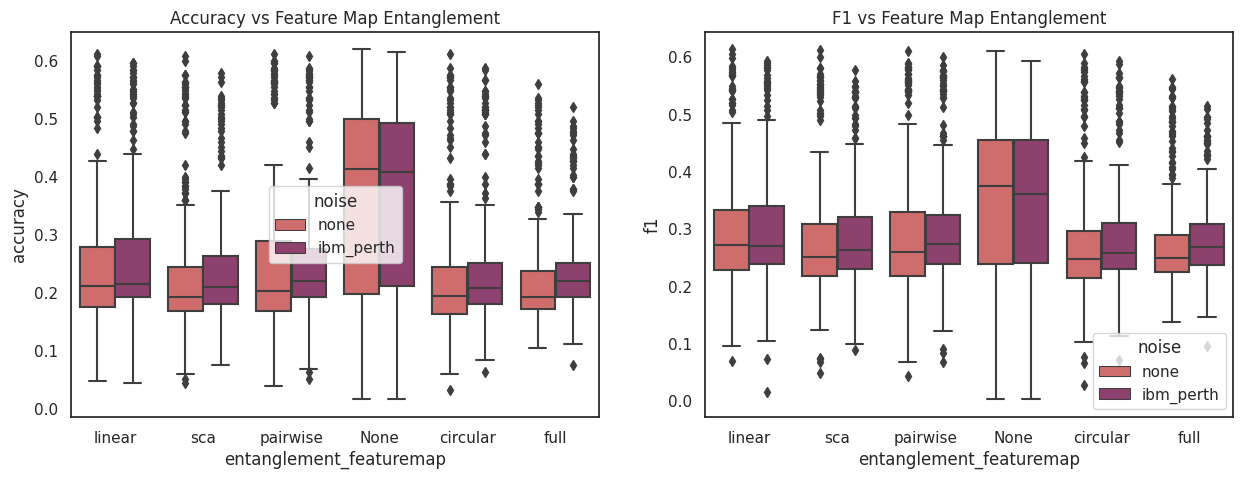

In [93]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
r = res.copy()
r.loc[r['entanglement_featuremap'].isna(), 'entanglement_featuremap'] = 'None'
sns.boxplot(data=r, x='entanglement_featuremap', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=r, x='entanglement_featuremap', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Feature Map Entanglement')
ax[1].set_title('F1 vs Feature Map Entanglement')
plt.show()


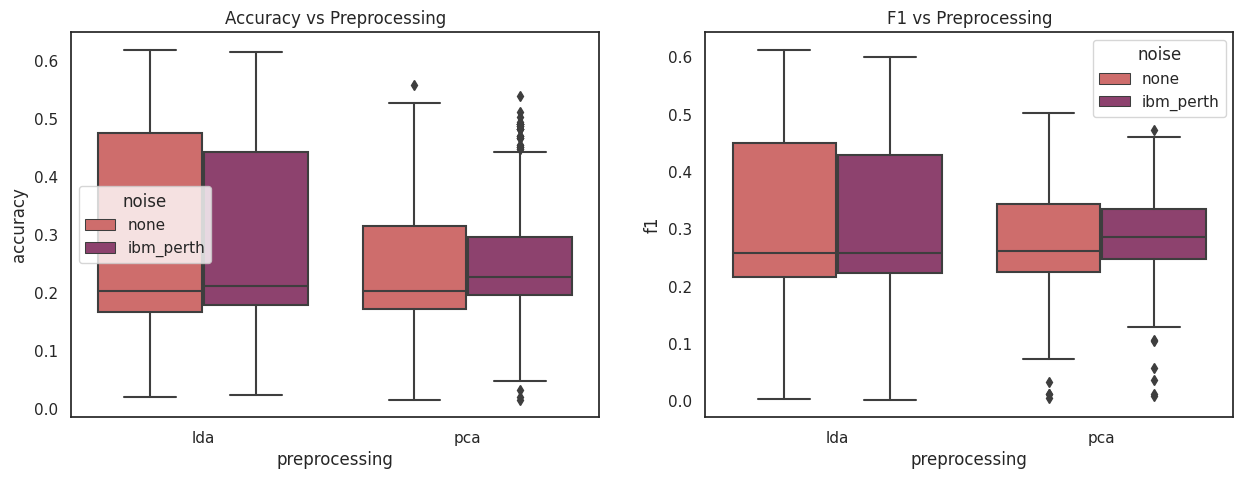

In [94]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
sns.boxplot(data=res, x='preprocessing', y='accuracy', hue='noise', palette='flare', ax=ax[0])
sns.boxplot(data=res, x='preprocessing', y='f1', hue='noise', palette='flare', ax=ax[1])
ax[0].set_title('Accuracy vs Preprocessing')
ax[1].set_title('F1 vs Preprocessing')
plt.show()

## Analyze Differences

In [95]:
diff.name = 'difference'
d = diff.reset_index()

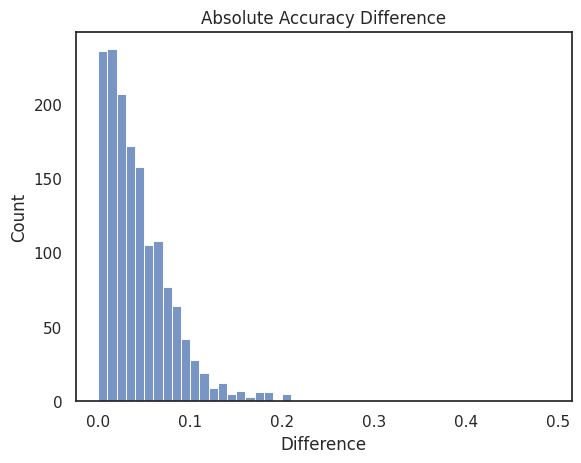

In [97]:
sns.histplot(d['difference'],bins=np.arange(0, 0.5, 0.01))
plt.title('Absolute Accuracy Difference')
plt.xlabel('Difference')
plt.ylabel('Count')
# plt.savefig("../reports/figures/covtype_absolute_differences.png", bbox_inches='tight')
plt.show()

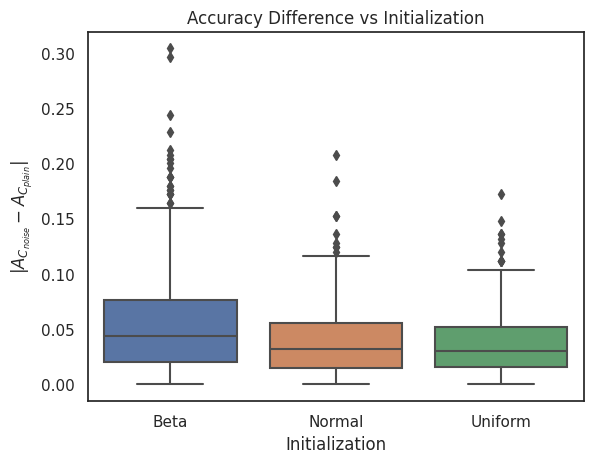

In [98]:
sns.boxplot(data=d, x='initialization', y='difference', palette='deep', order=['beta', 'normal', 'uniform'])
plt.xlabel("Initialization")
plt.xticks([0, 1, 2], ['Beta', 'Normal', 'Uniform'])
plt.ylabel("$|A_{C_{noise}} - A_{C_{plain}}|$")
plt.title("Accuracy Difference vs Initialization")
plt.savefig("../reports/figures/covtype_absolute_differences_initialization.png", bbox_inches='tight')
plt.show()

## Plot

In [99]:
d = diff.reset_index()
d

,ansatz,featuremap,entanglement,entanglement_featuremap,preprocessing,optimizer,initialization,difference
0,efficient_su2,z,circular,NaN,lda,cobyla,beta,0.008
1,efficient_su2,z,circular,NaN,lda,cobyla,normal,0.104
2,efficient_su2,z,circular,NaN,lda,cobyla,uniform,0.020
3,efficient_su2,z,circular,NaN,lda,nelder_mead,beta,0.204
4,efficient_su2,z,circular,NaN,lda,nelder_mead,normal,0.000
...,...,...,...,...,...,...,...,...
1507,two_local,zz,sca,sca,pca,nelder_mead,normal,0.000
1508,two_local,zz,sca,sca,pca,nelder_mead,uniform,0.060
1509,two_local,zz,sca,sca,pca,spsa,beta,0.040
1510,two_local,zz,sca,sca,pca,spsa,normal,0.056


In [100]:
diff.groupby(['initialization']).mean()

initialization
beta       0.055127
normal     0.038643
uniform    0.035881
Name: difference, dtype: float64